In [ ]:
#Sentiment Analysis on tweets about airlines. We will try to predict whether the comment is positive ,neutral or negative based on the tweet.

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [ ]:
df=pd.read_csv("/home/username/Downloads/Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
review_df = df[['text','airline_sentiment']]
print(review_df.shape)


(14640, 2)


In [6]:
review_df["airline_sentiment"].value_counts()
sentiment_label = review_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 0, ..., 0, 2, 0]),
 Index(['neutral', 'positive', 'negative'], dtype='object'))

In [ ]:
#Removing stopwords

In [24]:
from nltk.corpus import stopwords
stop=stopwords.words('english')
tweet=review_df.iloc[:,0].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
tweet.head()


0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus added commercials experien...
2    @VirginAmerica I today... Must mean I need tak...
3    @VirginAmerica really aggressive blast obnoxio...
4                  @VirginAmerica really big bad thing
Name: text, dtype: object

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)

In [26]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LeakyReLU
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(5001, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(70, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(40))
model.add(LeakyReLU(alpha=0.09))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 32)           160032    
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 200, 32)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 70)                28840     
_________________________________________________________________
dropout_12 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 40)                2840      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 40)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)               

In [84]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
366/366 [==============================] - 115s 309ms/step - loss: 0.7669 - accuracy: 0.6715 - val_loss: 0.5252 - val_accuracy: 0.7992
Epoch 2/5
366/366 [==============================] - 115s 314ms/step - loss: 0.5445 - accuracy: 0.7795 - val_loss: 0.4779 - val_accuracy: 0.8128
Epoch 3/5
366/366 [==============================] - 139s 380ms/step - loss: 0.4530 - accuracy: 0.8196 - val_loss: 0.4909 - val_accuracy: 0.8087
Epoch 4/5
366/366 [==============================] - 180s 492ms/step - loss: 0.4030 - accuracy: 0.8443 - val_loss: 0.4771 - val_accuracy: 0.8145
Epoch 5/5
366/366 [==============================] - 177s 484ms/step - loss: 0.3742 - accuracy: 0.8584 - val_loss: 0.5025 - val_accuracy: 0.8128


In [ ]:
#Testing the model on some data

In [85]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = np.argmax(model.predict(tw)[0])
    print("Predicted label: ", sentiment_label[1][prediction])
test_sentence1 = "I liked and enjoyed my journey on this flight."
predict_sentiment(test_sentence1)
test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

Predicted label:  positive
Predicted label:  negative


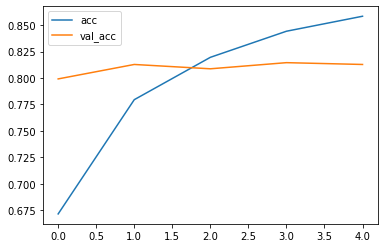

<Figure size 432x288 with 0 Axes>

In [86]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")